# Data Preparation


#### Import dependencies

In [82]:
import os
import re
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

sns.set_theme()

### Load the data into a Pandas dataframe
Define the path to the dataset file
Define the name of the label column

In [83]:
rootdir = os.getcwd()
infile = os.path.join(
    rootdir, "data", "Comedy_bang_bang_podcast_dataset-v16.csv"
)

df = pd.read_csv(infile)
df.dtypes

episode_number                                               int64
date_episode_published                                      object
data_set                                                    object
year_elligible_for_best_of                                   int64
duration_in_minutes                                          int64
episode_type                                                object
episode_title                                               object
guests_and_characters_from_wikipedia_semicolon_delimited    object
synopsis_and_segments                                       object
fandom_wikia_suffix                                         object
best_of_rank                                                object
is_on_best_of_boolean                                       object
dtype: object

#### Customized variables for this dataset

In [84]:
LABEL_COLUMN_NAME = "is_on_best_of_boolean"

NORMALIZE_METHOD = "min_max"

NUM_TOP_ACTORS_TO_ONE_HOT_ENCODE = 100
NUM_TOP_CHARS_TO_ONE_HOT_ENCODE = 50

INTERESTING_PERCENTILES = [0.1, 0.25, 0.40, 0.50, 0.632, 0.666, 0.75, 0.8, 0.9]


def get_stat(col_name, stat_name):
    """docstring TBD"""
    return df.describe(include="all").loc[stat_name].loc[col_name]


# Finding the percentiles:
def find_nearest_index(array, value):
    """docstring TBD"""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


df.head(10)

,episode_number,date_episode_published,data_set,year_elligible_for_best_of,duration_in_minutes,episode_type,episode_title,guests_and_characters_from_wikipedia_semicolon_delimited,synopsis_and_segments,fandom_wikia_suffix,best_of_rank,is_on_best_of_boolean
0,1,2009-05-01,ignored,2009,62,regular,Welcome To Comedy Bang Bang,Rob Huebel;Thomas Lennon;Doug Benson,NaN,https://comedybangbang.fandom.com/wiki/Welcome...,NaN,False
1,2,2009-05-08,ignored,2009,51,regular,Reggaeton Soundboard,Aziz Ansari;Kevin Nealon;Doug Benson,NaN,https://comedybangbang.fandom.com/wiki/Reggaet...,NaN,False
2,3,2009-05-15,ignored,2009,56,regular,Never Date A Brown,Jackie Clarke;Greg Behrendt;Nick Thune;Doug Be...,NaN,https://comedybangbang.fandom.com/wiki/Never_D...,NaN,False
3,4,2009-05-22,ignored,2009,49,guest_host,Special Nerdist Edition,Chris Hardwick;Matt Mira;Mike Phirman;Doug Benson,NaN,https://comedybangbang.fandom.com/wiki/Special...,NaN,False
4,5,2009-05-29,ignored,2009,52,guest_host,Guest Host Jimmy Pardo,Jimmy Pardo;Matt Belknap;Maria Bamford as Jazz...,NaN,https://comedybangbang.fandom.com/wiki/Guest_H...,NaN,False
5,6,2009-06-05,ignored,2009,56,regular,Doing Laundry with Sarah,Howard Kremer;Brett Gelman as James Gandolfini...,NaN,https://comedybangbang.fandom.com/wiki/Doing_L...,NaN,False
6,7,2009-06-12,ignored,2009,54,regular,Double Co-Hosts,The Sklar Brothers;Paul Rust as Cal Shipsby an...,NaN,https://comedybangbang.fandom.com/wiki/Double_...,NaN,False
7,8,2009-06-19,ignored,2009,57,regular,The New Doctor Demento,Weird Al Yankovic;Paul Scheer as Jim Pipe and ...,NaN,https://comedybangbang.fandom.com/wiki/The_New...,NaN,False
8,9,2009-06-26,ignored,2009,42,regular,R.I.P. Michael Jackson,Dax Shepard;Chip Pope as R.O. Mance;Paul F. To...,NaN,https://comedybangbang.fandom.com/wiki/R.I.P._...,NaN,False
9,10,2009-07-03,ignored,2009,71,regular,Comedy Vs. Music,Aimee Mann;Morgan Murphy;Seth Morris as Todd W...,NaN,https://comedybangbang.fandom.com/wiki/Comedy_...,NaN,False


In [85]:
# add a feature that tracks if the episode is divisible by 50 or 100
# Scott treats these episodes almost as anniversary episodes

df["hundo"] = df["episode_number"].mod(50) == 0
# df.loc[df['hundo'] == True]

## Removing columns that the model doesn't use
TBD

In [86]:
df.drop(
    columns=[
        "episode_number",
        "year_elligible_for_best_of",
        "episode_title",
        "synopsis_and_segments",
        "fandom_wikia_suffix",
        "best_of_rank",
    ],
    inplace=True,
)

df.dtypes

date_episode_published                                      object
data_set                                                    object
duration_in_minutes                                          int64
episode_type                                                object
guests_and_characters_from_wikipedia_semicolon_delimited    object
is_on_best_of_boolean                                       object
hundo                                                         bool
dtype: object

## Handling the Episode published Date

In [87]:
# converting the date
df["date_episode_published_datetime"] = pd.to_datetime(
    df["date_episode_published"], errors="raise"
)

# convert date to just the month
df["month_published_int"] = pd.DatetimeIndex(
    df["date_episode_published_datetime"]
).month

df.drop(
    columns=["date_episode_published", "date_episode_published_datetime"], inplace=True
)

df.dtypes

data_set                                                    object
duration_in_minutes                                          int64
episode_type                                                object
guests_and_characters_from_wikipedia_semicolon_delimited    object
is_on_best_of_boolean                                       object
hundo                                                         bool
month_published_int                                          int32
dtype: object

## Remove episodes released before the Best Of existed

In [88]:
# remove super old episodes that aren't useful
rows_to_drop = df[df["data_set"] == "ignored"].index
df.drop(rows_to_drop, inplace=True)

df["data_set"].unique()

array(['training', 'prediction'], dtype=object)

## Convert the label to a boolean

In [89]:
# convert label to Boolean
df["label"] = df[LABEL_COLUMN_NAME].astype("bool")
df.drop(columns=LABEL_COLUMN_NAME, inplace=True)

df.dtypes

data_set                                                    object
duration_in_minutes                                          int64
episode_type                                                object
guests_and_characters_from_wikipedia_semicolon_delimited    object
hundo                                                         bool
month_published_int                                          int32
label                                                         bool
dtype: object

## Winsorizing numerical outliers
Description TBD

In [90]:
# Winsorize the top 1% and bottom 1%
percentile = 0.01

for iter_column_name in df.select_dtypes(include=np.number).columns.tolist():
    new_column_name = iter_column_name + "_winsorized"

    winsorized_data = stats.mstats.winsorize(
        df[iter_column_name], limits=[percentile, percentile], inplace=False
    )

    if (winsorized_data == df[iter_column_name]).all():
        print(
            f"Winsorization on column {iter_column_name} had no effect. Not changing this column."
        )
        continue

    df[new_column_name] = winsorized_data
    df.drop(columns=iter_column_name, inplace=True)
    print(
        f"Winsorized column {iter_column_name} to {new_column_name} and removed original column."
    )

Winsorized column duration_in_minutes to duration_in_minutes_winsorized and removed original column.
Winsorized column month_published_int to month_published_int_winsorized and removed original column.


## Replacing missing numerical values w/ their mean
Description TBD

In [91]:
for iter_column_name in df.select_dtypes(include=np.number).columns.tolist():
    num_missing = np.sum(df[iter_column_name].isnull(), axis=0)

    if num_missing > 0:
        new_column_name = iter_column_name + "_replacedMissing"
        mean = get_stat(iter_column_name, "mean")

        df[new_column_name] = df[iter_column_name].fillna(value=mean, inplace=False)
        df.drop(columns=iter_column_name, inplace=True)

        # TODO: get a count of the number changed.
        print(
            f"Replaced missing values in column {iter_column_name} with the mean and created new column {new_column_name}. Removed original column"
        )
    else:
        print(
            f"No missing values detected in column {iter_column_name}, no changes made. Original column left intact."
        )

No missing values detected in column duration_in_minutes_winsorized, no changes made. Original column left intact.
No missing values detected in column month_published_int_winsorized, no changes made. Original column left intact.


## Normalizing numerical ranges
Description TBD

In [92]:
def normalize(df_local, column_name, normalize_method_name):
    """docstring TBD"""
    df_temp = df_local.copy()
    new_columnname = column_name + "_normalized"

    if normalize_method_name == "absolute_range":
        df_temp[new_columnname] = (
            df_temp[column_name] / df_temp[column_name].abs().max()
        )

    elif normalize_method_name == "min_max":
        # rescales a features to be in the range [0,1]
        df_temp[new_columnname] = (
            df_temp[column_name] - df_temp[column_name].min()
        ) / (df_temp[column_name].max() - df_temp[column_name].min())

    elif normalize_method_name == "z_score":
        df_temp[new_columnname] = (
            df_temp[column_name] - df_temp[column_name].mean()
        ) / df_temp[column_name].std()

    else:
        raise NameError("Unrecogized normalization method")

    df_temp.drop(columns=column_name, inplace=True)
    print(
        f"Normalized column {column_name} into {new_columnname} using {normalize_method_name}. Removed original."
    )
    return df_temp


# iterate through the list of current numeric columns
for iter_column_name in df.select_dtypes(include=np.number).columns.tolist():
    df = normalize(df, iter_column_name, NORMALIZE_METHOD)

Normalized column duration_in_minutes_winsorized into duration_in_minutes_winsorized_normalized using min_max. Removed original.
Normalized column month_published_int_winsorized into month_published_int_winsorized_normalized using min_max. Removed original.


## Converting actors and characters to one-hot encoded columns
Locate string columns that have a small number of unique values and replace them with one-hot encoded versions, then remove the original column.

In [93]:
# create a one-hot encoded version in a new dataframe
temp_df = pd.get_dummies(df["episode_type"], prefix="episode_type_")

# merge the new dataframe into the existing one
df.join(temp_df)

# remove the original column now that it has been encoded

# into the existing dataframe
df.drop(columns="episode_type", inplace=True)

# Prepare the Actors and Characters features for one-hot encoding

In [94]:
REPLACE_LIST_IN_CHAR = {
    "himself": "",
    "herself": "",
    "themself": "",
    " and ": ";",
    ",": ";",
    "  ": " ",
    ";;": ";",
}


def convert_cbb_guest_and_character_list3(
    single_episode_guest_list_str: str,
) -> list["str"]:
    """Takes the ; delimited list of guests and characters for a single
    episode. Converts them into two arrays: one for guests (actors) and one
    for characters"""

    # split out the episode guest list string into an array using the delimiter
    single_episode_guest_list_array = single_episode_guest_list_str.split(";")

    # define empty arrays
    actors = ""
    characters = "none"

    # iterate through each guest/actor and what characters they play (if any)
    for iter_str in single_episode_guest_list_array:
        next_actor, next_character = convert_cbb_guest_instance_to_strings2(iter_str)

        # add the actor if there is one
        if len(next_actor) == 0:
            continue
        if actors == "":
            actors = str(next_actor)
        else:
            next_actor = str(next_actor)
            actors = str(actors) + ";" + str(next_actor)

        # add the character(s) if there are at least 1
        if len(next_character) == 0:
            continue

        if len(next_character) == 1:
            characters = next_character[0]
        else:
            for ch in next_character:
                if characters == "none":
                    characters = str(ch)
                else:
                    characters = str(characters) + ";" + str(ch)

    return str(actors), str(characters)


def replace_all_as_str(text: str, dic: dict) -> str:
    """searches a string and replaces all instances of found key/values"""
    for i, j in dic.items():
        text = text.replace(i, j)
    return str(text)


def convert_cbb_guest_instance_to_strings2(single_guest_appearance_as_str: str):
    """Converts a string that has a single guest and one or more characters
    a list of actors (Guests) and a list of characters they play"""

    # make sure it's not empty string
    assert len(single_guest_appearance_as_str) > 0

    # make sure it doesn't have a reserved delimiter in it
    assert not re.search(";", single_guest_appearance_as_str)

    # if the guest plays at least one character, it will have ' as ' in it
    if re.search(" as ", single_guest_appearance_as_str):
        # extract guest name and list of characters
        actor_name, character_list_as_str = single_guest_appearance_as_str.split(
            " as ", 1
        )
        # strip out "as himself" or "as herself" and other non-characters
        character_list_as_array = replace_all_as_str(
            character_list_as_str, REPLACE_LIST_IN_CHAR
        ).split(";")
        if "" in character_list_as_array:
            character_list_as_array.remove("")
        # remove both leading and trailing whitespace from the character name
        character_list_as_array = [i.strip() for i in character_list_as_array]
        return str(actor_name), character_list_as_array

    # else isn't necessary, got dinged by PyLint on it
    # guest doesn't play a character, just themselves
    # return an empty array for character list
    # assert not re.search(',', single_guest_appearance_as_str)
    # assert not re.search('/', single_guest_appearance_as_str)
    return str(single_guest_appearance_as_str), ""


##############################################################################
# initialize some empty object columns
df["actors"] = [[]] * len(df.index)
df["characters"] = [[]] * len(df.index)
df["num_actors"] = 0 * len(df.index)  # set default to zero, important
df["num_chars"] = 0 * len(df.index)  # set default to zero, important

actor_counter = Counter([])
char_counter = Counter([])

for ind in df.index:
    orig = df["guests_and_characters_from_wikipedia_semicolon_delimited"][ind]

    actors_str, characters_str = convert_cbb_guest_and_character_list3(orig)

    actors_list = actors_str.split(";")
    char_list = characters_str.split(";")
    actor_counter.update(actors_list)
    char_counter.update(char_list)

    # assignment:
    df.loc[df.index == ind, "actors"] = actors_str
    df.loc[df.index == ind, "characters"] = characters_str

    if actors_str != "none":
        df.loc[df.index == ind, "num_actors"] = actors_str.count(";") + 1

    if characters_str != "none":
        df.loc[df.index == ind, "num_chars"] = characters_str.count(";") + 1

# remove the original column
df.drop(
    columns="guests_and_characters_from_wikipedia_semicolon_delimited", inplace=True
)

df.head(5)

,data_set,hundo,label,duration_in_minutes_winsorized_normalized,month_published_int_winsorized_normalized,actors,characters,num_actors,num_chars
34,training,False,True,0.000000,0.000000,Thomas Lennon;Patton Oswalt;Brett Gelman,Little Gary;Chris Mindy,3,2
35,training,False,False,0.024390,0.000000,Jerry Minor;Matt Besser;Sean Dickerson,Miles Archer,3,1
36,training,False,False,0.012195,0.000000,Sarah Silverman;Todd Glass;Hannibal Buress,none,3,0
37,training,False,False,0.000000,0.000000,Paul F. Tompkins;Kaitlin Olson;Matt Gourley;Je...,none,5,0
38,training,False,False,0.060976,0.090909,Garfunkel and Oates;Seth Morris;Brendon Walsh,Bob Ducca,3,1


# Analyzing Actor/Character counts in preparation for one-hot encoding

# of unique actors: 558
# of actor appearances: 2678
10.0% coverage requires   2 actors
25.0% coverage requires  11 actors
40.0% coverage requires  25 actors
50.0% coverage requires  41 actors
63.2% coverage requires  75 actors
66.6% coverage requires  87 actors
75.0% coverage requires 127 actors
80.0% coverage requires 163 actors
90.0% coverage requires 289 actors


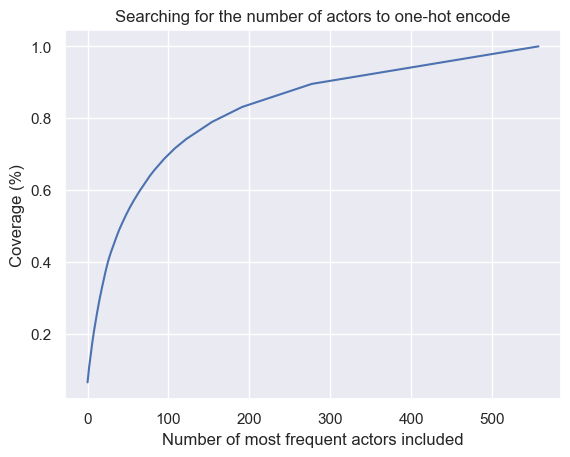

In [95]:
# Analyzing the actor counts

number_of_unique_actors = len(actor_counter.keys())
number_of_total_actor_appearances = actor_counter.total()

print(f"# of unique actors: {number_of_unique_actors}")
print(f"# of actor appearances: {number_of_total_actor_appearances}")

vals_array = np.array(actor_counter.most_common())[:, 1]
csum = np.cumsum(vals_array, dtype=int) / number_of_total_actor_appearances

fig, ax = plt.subplots()
ax.plot(csum)
ax.set(
    xlabel="Number of most frequent actors included",
    ylabel="Coverage (%)",
    title="Searching for the number of actors to one-hot encode",
)

for iter_interesting_value in INTERESTING_PERCENTILES:
    # TBD
    i2 = find_nearest_index(csum, iter_interesting_value)
    p = iter_interesting_value * 100
    print(f"{p:.1f}% coverage requires {i2:3} actors")

# of unique chars: 715
# of char appearances: 1035
10.0% coverage requires   6 chars
25.0% coverage requires  34 chars
40.0% coverage requires 102 chars
50.0% coverage requires 196 chars
63.2% coverage requires 333 chars
66.6% coverage requires 368 chars
75.0% coverage requires 455 chars
80.0% coverage requires 507 chars
90.0% coverage requires 611 chars


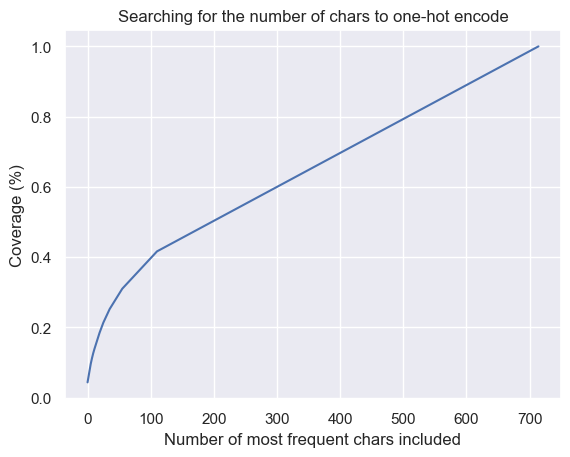

In [96]:
# Analyzing the char counts

number_of_unique_chars = len(char_counter.keys())
number_of_total_char_appearances = char_counter.total()

print(f"# of unique chars: {number_of_unique_chars}")
print(f"# of char appearances: {number_of_total_char_appearances}")

vals_array = np.array(char_counter.most_common())[:, 1]
csum = np.cumsum(vals_array, dtype=int) / number_of_total_char_appearances

fig, ax = plt.subplots()
ax.plot(csum)
ax.set(
    xlabel="Number of most frequent chars included",
    ylabel="Coverage (%)",
    title="Searching for the number of chars to one-hot encode",
)

for iter_interesting_value in INTERESTING_PERCENTILES:
    i1 = find_nearest_index(csum, iter_interesting_value)
    p = iter_interesting_value * 100
    print(f"{p:.1f}% coverage requires {i1:3} chars")

# One hot encoding the actor and character features

In [97]:
# TODO: investigate what happens when actors or characters = 'none'
#     is that the expected behavior that models what the show is doing?

# https://stackoverflow.com/questions/46864816/convert-pandas-dataframe-column-of-comma-separated-strings-to-one-hot-encoded
# loop through ; delimited string columns that need to be one-hot encoded
for iter_column_name in ['actors', 'characters']:
   
   # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.add_prefix.html
   # create a new dataframe that has the one-hot encoded versions of those
   # ; delimited original column
   df_temp = (df[iter_column_name].str.split(r'\s*;\s*', expand=True)
      .apply(pd.Series.value_counts, 1)
      .iloc[:, 1:]
      .fillna(0, downcast='infer'))
   
   # add a prefix so that its easier to sort and distinguish
   new_column_prefix = iter_column_name + '_'
   df_temp = df_temp.add_prefix(new_column_prefix)

   # join the two, don't use join or merge here
   df = pd.concat([df, df_temp], axis=1)
   
   # remove the original column
   df.drop(columns=iter_column_name, inplace=True)
   
   for iter_col in df.filter(like=new_column_prefix).columns:
      df[iter_col] = df[iter_col].astype('bool')

df.dtypes

data_set                                      object
hundo                                           bool
label                                           bool
duration_in_minutes_winsorized_normalized    float64
month_published_int_winsorized_normalized    float64
                                              ...   
characters_none                                 bool
characters_the Mailer Daemon                    bool
characters_the Pie Minister                     bool
characters_themselves                           bool
characters_Étouffée                             bool
Length: 1278, dtype: object

# Re-order the columns
Sort the column names alphabetically, but make sure the 'label' column is always last.

In [98]:
# alphabetically sort the column names, but leave the label as the last column
column_order = sorted(df.columns)
column_order.remove("label")
column_order.append("label")
df = df.reindex(column_order, axis=1)

# Final tests

In [99]:
# check for missing values
# check for any remaining strings
df.describe(include="all")

,actors_Adam Brody,actors_Adam Cayton-Holland,actors_Adam DeVine,actors_Adam Pally,actors_Adam Resnick,actors_Adam Scott,actors_Aimee Mann,actors_Aisling Bea,actors_Al Madrigal,actors_Alan Tudyk,...,characters_the Pie Minister,characters_themselves,characters_Étouffée,data_set,duration_in_minutes_winsorized_normalized,hundo,month_published_int_winsorized_normalized,num_actors,num_chars,label
count,804,804,804,804,804,804,804,804,804,804,...,804,804,804,804,804.000000,804,804.000000,804.000000,804.000000,804
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,NaN,2,NaN,NaN,NaN,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,training,NaN,False,NaN,NaN,NaN,False
freq,802,800,800,796,803,791,801,803,803,803,...,803,803,803,750,NaN,788,NaN,NaN,NaN,570
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.281307,NaN,0.479534,3.330846,1.231343,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.176293,NaN,0.301976,2.009936,1.260063,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,1.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.170732,NaN,0.181818,3.000000,1.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.256098,NaN,0.454545,3.000000,1.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.353659,NaN,0.727273,4.000000,1.000000,NaN


In [100]:
# show the final datatypes before exporting to CSV
df.dtypes

actors_Adam Brody                               bool
actors_Adam Cayton-Holland                      bool
actors_Adam DeVine                              bool
actors_Adam Pally                               bool
actors_Adam Resnick                             bool
                                              ...   
hundo                                           bool
month_published_int_winsorized_normalized    float64
num_actors                                     int64
num_chars                                      int64
label                                           bool
Length: 1278, dtype: object

# Storing training and prediction data into CSV files

In [101]:
output_file_prefix = os.path.splitext(infile)[0]

# Create a training/test dataset and output to CSV
df_training = df.copy()
non_training_rows = df_training[df_training["data_set"] != "training"].index
df_training.drop(non_training_rows, inplace=True)
df_training.drop(columns="data_set", inplace=True)

training_outfile = output_file_prefix + "_train.csv"
df_training.to_csv(training_outfile, index=False)
print(f"Training data saved to new CSV file:\n{training_outfile}")


# Create a prediction dataset and output to CSV
df_predict = df.copy()
non_prediction_rows = df_predict[df_predict["data_set"] != "prediction"].index
df_predict.drop(non_prediction_rows, inplace=True)
df_predict.drop(columns="data_set", inplace=True)

predict_outfile = output_file_prefix + "_predict.csv"
df_predict.to_csv(predict_outfile, index=False)
print(f"Prediction data saved to new CSV file:\n{predict_outfile}")

Training data saved to new CSV file:
/Users/the-molecular-man/source_code/machine-learning/comedy_bang_bang_podcast/data/Comedy_bang_bang_podcast_dataset-v16_train.csv
Prediction data saved to new CSV file:
/Users/the-molecular-man/source_code/machine-learning/comedy_bang_bang_podcast/data/Comedy_bang_bang_podcast_dataset-v16_predict.csv
